<h1>Assignment 7: programming</h1>

This is the programming part of Assignment 7. When you're done, select "Restart and run all" in the Kernel menu, and make sure your code behaves as you expect. There is a theoretical part of the assignment also, found in the Handouts folder on CoCalc, which must be handed in at the <i>start</i> of class on Friday, November 29.

First, run the following code to import packages that we'll need.

In [1]:
import numpy as np
np.set_printoptions(precision=10)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<h2>QR factorization</h2>

<h4>a.</h4>
Complete the following function that returns the QR factorization of a matrix $A$. You can assume the columns of $A$ are linearly independent. The matrices $A$ and $Q$ should be the same size.

In [2]:
def QR(A):
    Q, R = np.linalg.qr(A)
    m , n = np.shape(A)
    Q = np.zeros((m,n))
    R = np.zeros((n,n))
    for j in range(n):
        y = A[:,j]
        for i in range(j):
            R[i,j] = np.dot(np.transpose(Q[:,i]),A[:,j])
            y = y - R[i,j]*Q[:,i]
        R[j,j] = np.linalg.norm(y)
        Q[:,j] = y/R[j,j]
    return Q, R

The following code should output the QR factorization of the matrix from part 1 of the theory assignment.

In [3]:
A = np.array([[2., 2],[1,1],[2,-1],[0,2]])
A = np.array([[2, 4],[0,-1],[2,-1],[1,3]])
Q, R = QR(A)
print(Q), print(R)

[[ 0.6666666667  0.4714045208]
 [ 0.           -0.2357022604]
 [ 0.6666666667 -0.7071067812]
 [ 0.3333333333  0.4714045208]]
[[3.           3.          ]
 [0.           4.2426406871]]


(None, None)

<h4>b.</h4>

Here's a version of the back substitution function from assignment 6. The input is a square upper triangular matrix $U$ and a vector $b$. You can use this if you want, or delete it and use your own code.

In [4]:
def back_sub(U,b):
    n = b.shape[0]
    x = np.zeros(n)
    x[-1] = b[-1] / U[-1,-1]
    for i in range(n-2,-1,-1):
        x[i] = 1/U[i,i] * ( b[i] - np.sum( U[i,i+1:]*x[i+1:]) )
    return x

Complete the following function that returns the the least squares solution $\bar x$ to $Ax=b$, given the QR factorization of $A$. You can use my <tt>back_sub</tt> routine if you want.

In [5]:
def QR_ls(Q,R,b):
    d = np.dot(np.transpose(Q),b)
    n = np.size(Q)
    R_hat = R[0:n,0:n]
    d_hat = d[0:n]
    return back_sub(R_hat, d_hat)

<h4>c.</h4>

Let $f(x)= e^x$. Let the $x_i$ be uniformly spaced from $x_1=-1$ to $x_6=1$. Suppose we want to approximate $f(x)$ by a parabola $p(x)=c_0+c_1x+c_2x^2$. This $p(x)$ does not have high enough degree to interpolate $f(x)$ at the $x_i$. Instead, let's minimize the least squares error of the vector in $\mathbb R^6$ whose entries are $f(x_i)-p(x_i)$. To do this, formulate a matrix equation for the vector $\mathbf{c}=\begin{bmatrix}c_0&c_1&c_2\end{bmatrix}^T$ like on assignment 6. In the present case this system is inconsistent. Find its least squares solution, $\bar{\mathbf{c}}$, using the functions from parts 1a and 1b.

In [6]:
def f(x):
    return np.exp(x)
x = np.linspace(-1,1,6)
A = np.zeros((6,3))
b = np.zeros(6)
for i in range(6):
    b[i] = f(x[i])
    A[i] = np.array([1,x[i],x[i]*x[i]])
Q , R = QR(A)
c = QR_ls(Q,R,b)
print(c)

[0.9943634807 1.1410432453 0.5468015476]


Record your answer by assigning the following variables.

In [7]:
c0 = c[0]
c1 = c[1]
c2 = c[2]

Run the following code to compare your $f(x)$ and $p(x)$ functions. The $p(x)$ function should provide a close approximation to $f(x)$ despite not agreeing exactly at the interpolation points. 

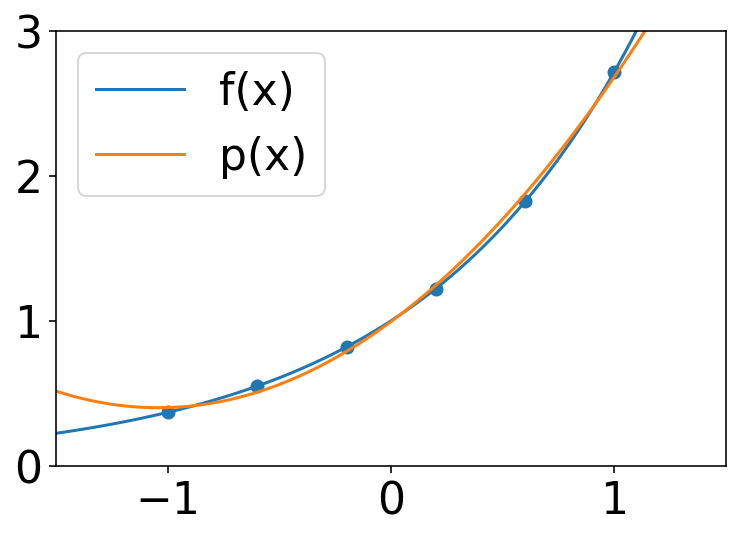

In [8]:
x = np.linspace(-1.5,1.5,100)
p = np.zeros(len(x))
for i in range(0,len(x)):
    p[i] = np.dot( np.array([c0,c1,c2]) , np.power(x[i],np.array([0,1,2])) )

plt.figure()
plt.plot(x,f(x),label='f(x)')
plt.plot(x,p,label='p(x)')
xi = np.linspace(-1,1,6)
plt.scatter(xi,f(xi))
plt.axis([-1.5,1.5,0,3])
plt.legend();

<h2>2. GMRES</h2>

<h4> a. </h4>
Complete the following function to solve $Ax=b$ using the GMRES algorithm. At every step, compute the approximate solution $x_k$ and the relative backward error $e_k=\Vert b-Ax_k\Vert/\Vert b\Vert$, and store the $e_k$ values in an array. On the step when $e_k\le tol$, return the approximate solution $x_k$, as well as the array of $e_k$ values. If you were unable to get your QR factorization working, you can use NumPy's <tt>linalg.lstsq</tt> function to solve the least squares problem that is part of the GMRES algorithm. Test your function on a small system where you know the answer.

In [9]:
def gmres(A,b,tol,kmax):
    # OUTPUT:
    # x is a numpy array of length n
    # err is a numpy array of length no larger than kmax

    n = A.shape[1]
    x0 = np.zeros(n) # use the zero vector for the initial guess x0
    x = []
    err = []
    r = b - A@x0
    q = [0]*(kmax)
    bNorm = np.linalg.norm(b)
    rNorm = np.linalg.norm(r)
    q[0] = r/rNorm
    h = np.zeros((kmax+1 , kmax))
    x.append(r)
    err.append(np.linalg.norm(b - np.matmul(A,np.asarray(x[-1]))) / bNorm)
    for k in range(kmax):
        if (err[-1] < tol):
            break
        y = np.asarray(np.dot(A, q[k])).reshape(-1)
        for j in range(k+1):
            h[j,k] = np.dot(q[j], y)
            y = y - h[j, k] * q[j]
        h[k + 1, k] = np.linalg.norm(y)
        if (h[k + 1, k] != 0 and k != kmax - 1):
            q[k + 1] = y / h[k + 1, k]

        d = np.zeros(kmax + 1)
        d[0] = rNorm
        result = np.linalg.lstsq(h, d)[0]
        x.append(np.dot(np.asarray(q).transpose(), result) + x0)
        err.append(np.linalg.norm(b - np.matmul(A,np.asarray(x[-1]))) / bNorm)
    # your code here

    return np.asarray(x) , np.asarray(err)

The following code defines a sparse (banded) matrix $A\in\mathbb{R}^{300\times300}$ and a vector $b\in\mathbb{R}^{300}$ with all 1 entries. The matrix $A$ is not stored using a sparse data structure; instead all the zero entries are stored. Exploiting sparsity would decrease computational cost significantly.

In [10]:
n = 300
ints = np.linspace(1,n,n)
A = np.diag(np.power(-1,ints)*ints) + np.diag( np.cos(np.linspace(1,n,n-5)),5) + np.diag( np.cos(np.linspace(1,n,n-5)),-5) + np.diag( np.cos(np.linspace(1,n,n-10)),10) + np.diag( np.cos(np.linspace(1,n,n-10)),-10)
b = np.matmul(A,np.ones(n))

Use your <tt>gmres</tt> function to approximately solve $Ax=b$. Take <tt>kmax=100</tt> and <tt>tol=1e-15</tt>. Plot a <tt>scatter</tt> of the error vector $e_k$ (log scale) versus the step number $k$ (linear scale). For the plot axes, <tt>plt.axis([0,100,1e-3,10])</tt> should be appropriate.

/ext/anaconda5/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


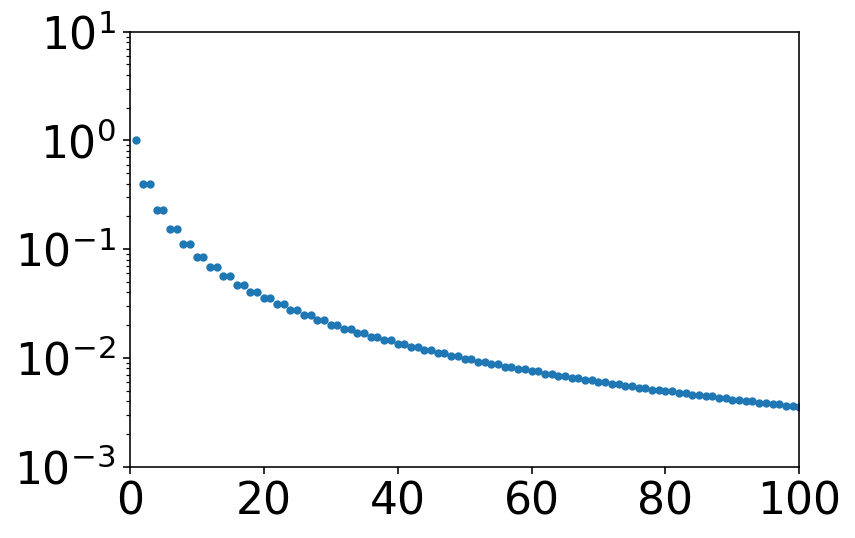

In [11]:
x , err =  gmres(A,b,1e-15,100)
plt.figure()
k = np.arange(np.size(err))
plt.scatter(k,err,s = 10)
plt.axis([0,100,1e-3,10])
#plt.xscale('log')
plt.yscale('log')



<h4> b. Preconditioned GMRES </h4>

Complete the following function that is like your <tt>gmres</tt> function, except that it uses the Jacobi preconditioner.

In [12]:
def gmres_jac(A,b,tol,kmax):
    
    n = A.shape[1]
    x0 = np.zeros(n)
    x = []
    err = []
    q = [0]*(kmax)
    Minv = 1 / np.diag(A) # a vector
    r = Minv*(b - A@x0)
    bNorm = np.linalg.norm(Minv@b)
    rNorm = np.linalg.norm(r)
    q[0] = r/rNorm
    h = np.zeros((kmax+1 , kmax))
    x.append(r)
    err.append(np.linalg.norm(b - np.matmul(A,np.asarray(x[-1]))) / bNorm)
    for k in range(kmax):
        if (err[-1] < tol):
            break
        w = np.asarray(Minv*A@(np.asarray(q[k]))).reshape(-1)
        for j in range(k+1):
            h[j,k] = np.dot(np.transpose(w), np.asarray(q[j]))
            w = w - h[j, k] * q[j]
        h[k + 1, k] = np.linalg.norm(w)
        if (h[k + 1, k] != 0 and k != kmax - 1):
            q[k + 1] = w / h[k + 1, k]

        d = np.zeros(kmax + 1)
        d[0] = rNorm
        result = np.linalg.lstsq(h, d)[0]
        x.append(np.dot((np.asarray(q).transpose()), result) + x0)
        err.append(np.linalg.norm(Minv*b - np.matmul(Minv*A,np.asarray(x[-1]))) / bNorm)
    x = np.asarray(x)
    err = np.asarray(err)
    return x , err

Make a plot that is analogous to the plot in part 2a, but this time showing the error at each step for preconditioned GMRES with the Jacobi preconditioner. Your axes will need to be different.

/ext/anaconda5/lib/python3.6/site-packages/ipykernel/__main__.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


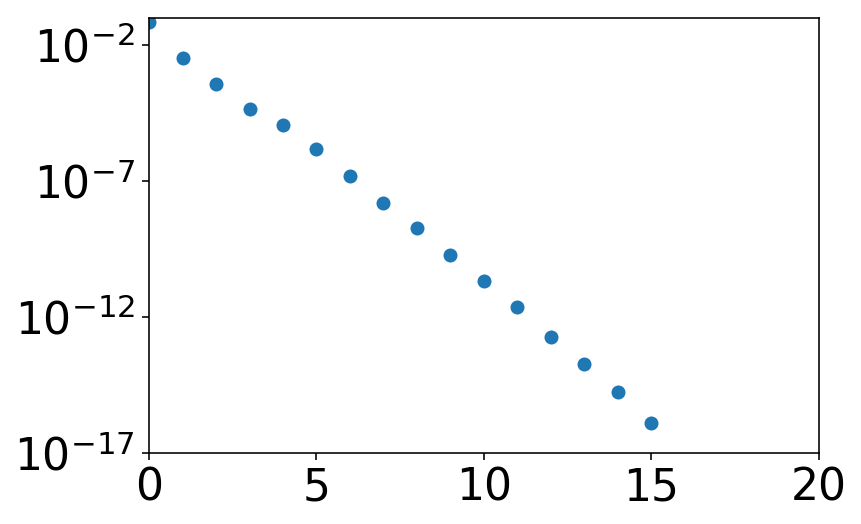

In [13]:
n = 300
ints = np.linspace(1,n,n)
A = np.diag(np.power(-1,ints)*ints) + np.diag( np.cos(np.linspace(1,n,n-5)),5) + np.diag( np.cos(np.linspace(1,n,n-5)),-5) + np.diag( np.cos(np.linspace(1,n,n-10)),10) + np.diag( np.cos(np.linspace(1,n,n-10)),-10)
b = np.matmul(A,np.ones(n))
x , err =  gmres_jac(A,b,1e-15,100)
plt.figure()
k = np.arange(np.size(err))
plt.scatter(k,err)
plt.axis([0,20,1e-17,1e-1])
#plt.xscale('log')
plt.yscale('log')


### 